<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/CNN_for_hymenoptera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Основное задание Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels

1.Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)

3.Добавьте аугментацию данных к пункту 2Сравните качество всех 3 полученных подходов

Задание со звездочкойПримените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision as tv
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import time

# Импорт датасета из Кегли

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kucherevskiy","key":"b0045601205279989b8a26ed266afc93"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ajayrana/hymenoptera-data

 81% 73.0M/90.2M [00:01<00:00, 38.5MB/s]
100% 90.2M/90.2M [00:01<00:00, 69.1MB/s]


In [ ]:
! unzip hymenoptera-data.zip

In [ ]:
# удаление лишней папки hymenoptera_data/hymenoptera_data
!rm -rf hymenoptera_data/hymenoptera_data

## Подготовка данных без аугментации

In [ ]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                  }
BATCH_SIZE = 6 
train_dataset = datasets.ImageFolder('hymenoptera_data/train',transform = data_transforms['train'])
test_dataset = datasets.ImageFolder('hymenoptera_data/val',transform = data_transforms['val'])
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")                

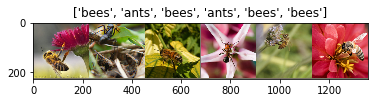

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        insects = ('bees' if label else 'ants' for label in title)
        plt.title(list(insects))
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_iter))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out,title = classes)

In [ ]:
train_dataset[1][0].shape

torch.Size([3, 224, 224])

### 1.1 RESNET 18 с нуля


In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
               % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
model = tv.models.resnet18(pretrained=False)

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 1.1383, train acc 0.553, test acc 0.458, time 3.9 sec
epoch 2, loss 1.2277, train acc 0.557, test acc 0.490, time 3.7 sec
epoch 3, loss 1.0517, train acc 0.529, test acc 0.458, time 3.7 sec
epoch 4, loss 1.2610, train acc 0.570, test acc 0.556, time 3.7 sec
epoch 5, loss 0.7841, train acc 0.549, test acc 0.562, time 3.6 sec
epoch 6, loss 0.8557, train acc 0.516, test acc 0.523, time 3.6 sec
epoch 7, loss 0.7380, train acc 0.590, test acc 0.641, time 3.6 sec
epoch 8, loss 0.7812, train acc 0.627, test acc 0.641, time 3.6 sec
epoch 9, loss 0.6790, train acc 0.607, test acc 0.569, time 3.6 sec
epoch 10, loss 0.6970, train acc 0.648, test acc 0.601, time 3.6 sec


Тестовая точность ResNet18 после 10 эпох 64 %


## 1.2 VGG 16 с нуля

In [ ]:
model = tv.models.vgg16(pretrained=False)

In [ ]:
model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [ ]:
classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 2))

In [ ]:
model.add_module('classifier', classifier)

In [ ]:
model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [ ]:
model.to(device)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.7060, train acc 0.418, test acc 0.477, time 5.8 sec
epoch 2, loss 0.6900, train acc 0.549, test acc 0.542, time 5.8 sec
epoch 3, loss 0.7046, train acc 0.484, test acc 0.542, time 5.8 sec
epoch 4, loss 0.6934, train acc 0.496, test acc 0.458, time 5.8 sec
epoch 5, loss 0.6922, train acc 0.541, test acc 0.614, time 5.8 sec
epoch 6, loss 0.6866, train acc 0.561, test acc 0.510, time 5.8 sec
epoch 7, loss 0.6868, train acc 0.533, test acc 0.536, time 5.8 sec
epoch 8, loss 0.6222, train acc 0.635, test acc 0.588, time 5.8 sec
epoch 9, loss 0.6373, train acc 0.643, test acc 0.464, time 5.8 sec
epoch 10, loss 0.6947, train acc 0.566, test acc 0.569, time 5.8 sec


Максимальная точность VGG 16 без предварительной тренировки 61 % после 10 эпох

## 2. Fine tuning RESNET 18, VGG 16

## 2.1 RESNET 18

In [ ]:
model = tv.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
## Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
model.to(device)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.4938, train acc 0.820, test acc 0.810, time 3.1 sec
epoch 2, loss 0.5705, train acc 0.840, test acc 0.732, time 3.1 sec
epoch 3, loss 1.7507, train acc 0.750, test acc 0.797, time 3.1 sec
epoch 4, loss 0.5569, train acc 0.889, test acc 0.869, time 3.1 sec
epoch 5, loss 0.6260, train acc 0.873, test acc 0.804, time 3.1 sec
epoch 6, loss 0.3640, train acc 0.918, test acc 0.843, time 3.1 sec
epoch 7, loss 0.4461, train acc 0.885, test acc 0.869, time 3.1 sec
epoch 8, loss 1.0230, train acc 0.820, test acc 0.863, time 3.1 sec
epoch 9, loss 0.6913, train acc 0.902, test acc 0.902, time 3.1 sec
epoch 10, loss 0.2963, train acc 0.934, test acc 0.863, time 3.1 sec


Качество на предварительно обученной модели RESNET 18 улучшилось с 64 до 90 процентов

## 2.2 VGG 16

In [ ]:
model = tv.models.vgg16(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 2))

In [ ]:
model.classifier = classifier

In [ ]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.7.weight
	 classifier.7.bias


In [ ]:
model.to(device)

In [ ]:
lr, num_epochs = 0.00001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.6348, train acc 0.689, test acc 0.712, time 4.4 sec
epoch 2, loss 0.5200, train acc 0.836, test acc 0.810, time 4.3 sec
epoch 3, loss 0.4110, train acc 0.926, test acc 0.935, time 4.3 sec
epoch 4, loss 0.3306, train acc 0.963, test acc 0.915, time 4.3 sec
epoch 5, loss 0.2699, train acc 0.984, test acc 0.922, time 4.3 sec
epoch 6, loss 0.2319, train acc 0.975, test acc 0.922, time 4.2 sec
epoch 7, loss 0.2003, train acc 0.984, test acc 0.941, time 4.3 sec
epoch 8, loss 0.1735, train acc 0.971, test acc 0.922, time 4.3 sec
epoch 9, loss 0.1590, train acc 0.984, test acc 0.941, time 4.3 sec
epoch 10, loss 0.1335, train acc 0.988, test acc 0.954, time 4.3 sec


Качество на предварительно обученной модели VGG 16 увеличилось с 61 до 95%, для обучения нужен меньший learning rate

## 3. Обучение с аугментацией

In [ ]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(
        (200, 200), scale=(0.1, 1), ratio=(0.5, 2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                  }
BATCH_SIZE = 6 
train_dataset = datasets.ImageFolder('hymenoptera_data/train',transform = data_transforms['train'])
test_dataset = datasets.ImageFolder('hymenoptera_data/val',transform = data_transforms['val'])
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

## 3.1 Обучение с аугментацией для RESNET 18

In [ ]:
model = tv.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=2)

print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
model.to(device)

In [ ]:
lr, num_epochs = 0.0001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.5810, train acc 0.824, test acc 0.863, time 3.3 sec
epoch 2, loss 0.4681, train acc 0.881, test acc 0.889, time 3.3 sec
epoch 3, loss 0.8128, train acc 0.824, test acc 0.863, time 3.2 sec
epoch 4, loss 0.7750, train acc 0.852, test acc 0.856, time 3.2 sec
epoch 5, loss 0.3860, train acc 0.861, test acc 0.876, time 3.2 sec
epoch 6, loss 0.4169, train acc 0.881, test acc 0.876, time 3.2 sec
epoch 7, loss 0.4392, train acc 0.885, test acc 0.902, time 3.2 sec
epoch 8, loss 0.5705, train acc 0.861, test acc 0.804, time 3.2 sec
epoch 9, loss 0.4586, train acc 0.873, test acc 0.876, time 3.3 sec
epoch 10, loss 0.5382, train acc 0.865, test acc 0.876, time 3.3 sec


Качество практически не изменилось

## 3.2 Обучение с аугментацией для VGG 16

In [ ]:
model = tv.models.vgg16(pretrained=True)
classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 2))
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier = classifier


In [ ]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.7.weight
	 classifier.7.bias


In [ ]:
model.to(device)

In [ ]:
lr, num_epochs = 0.00001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.6796, train acc 0.582, test acc 0.654, time 4.3 sec
epoch 2, loss 0.6448, train acc 0.656, test acc 0.745, time 4.3 sec
epoch 3, loss 0.6133, train acc 0.689, test acc 0.784, time 4.3 sec
epoch 4, loss 0.6010, train acc 0.758, test acc 0.869, time 4.3 sec
epoch 5, loss 0.5671, train acc 0.811, test acc 0.869, time 4.3 sec
epoch 6, loss 0.5432, train acc 0.857, test acc 0.935, time 4.3 sec
epoch 7, loss 0.4993, train acc 0.869, test acc 0.922, time 4.3 sec
epoch 8, loss 0.4836, train acc 0.865, test acc 0.915, time 4.3 sec
epoch 9, loss 0.4359, train acc 0.889, test acc 0.935, time 4.3 sec
epoch 10, loss 0.4160, train acc 0.889, test acc 0.935, time 4.3 sec


Для VGG 16 качество также практически не изменилось, по-видимому это связано с тем, что исходные данные изначально разнообразны и не ориентированы относительно сторон картинки.

## 4. Fine tuning RESNET 18  для FASHION MNIST

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),                        
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()]
        ),
    'val': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor()])
                  }
BATCH_SIZE = 500
train_dataset = datasets.FashionMNIST('.', train=True, transform=data_transforms['train'], download=True)
test_dataset = datasets.FashionMNIST('.', train=False, transform=data_transforms['val'], download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True)

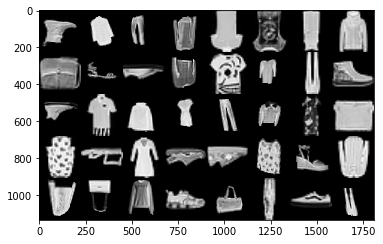

In [ ]:
# для BATCH_size = 40
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_iter))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out,title = classes)

In [ ]:
model = tv.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model.to(device)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 4.6951, train acc 0.701, test acc 0.797, time 254.6 sec
epoch 2, loss 4.0493, train acc 0.732, test acc 0.716, time 253.8 sec
epoch 3, loss 3.2857, train acc 0.748, test acc 0.730, time 249.4 sec
epoch 4, loss 3.9989, train acc 0.734, test acc 0.774, time 247.6 sec
epoch 5, loss 3.2810, train acc 0.736, test acc 0.733, time 250.1 sec


KeyboardInterrupt: ignored

На предварительно обученной сети RESNET 18 не удается повысить качество за приемлемое количество эпох

In [ ]:
model = tv.models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=512, out_features=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model.to(device)

In [ ]:
lr, num_epochs = 0.001, 20
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, device)